In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import copy

T_START = 0
T_END = 1

NUM_EPOCHS = 30000
LEARNING_RATE = 1e-4
NUM_POINTS = 10000
NUM_COLLOCATION = 100000
PATIENCE = 1000
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 1

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


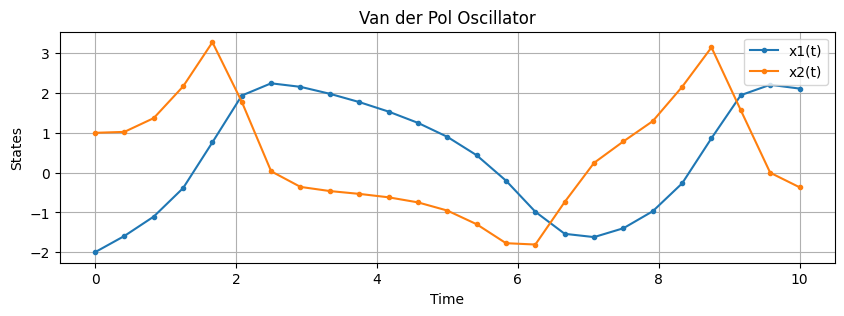

In [4]:
def u(t):
    return 0.45

# Define the Van der Pol oscillator ODEs
def vdp_odes(x, t, mu):
    x1, x2 = x
    dx1dt = x2
    dx2dt = mu * (1 - x1**2) * x2 - x1 + u(t)
    return [dx1dt, dx2dt]

# Set the initial conditions
y0 = [-2, 1]
mu = 1
t = np.linspace(T_START, 10 * T_END, 25)

# Solve the ODEs
sol = odeint(vdp_odes, y0, t, args=(mu,))

# Plotting the results
plt.figure(figsize=(10, 3))
plt.plot(t, sol[:, 0], marker='o', markersize=3, label='x1(t)')
plt.plot(t, sol[:, 1], marker='o', markersize=3, label='x2(t)')
plt.title('Van der Pol Oscillator')
plt.xlabel('Time')
plt.ylabel('States')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Generate a dataset
df = pd.DataFrame(columns=['t', 'x1', 'x2', 'u'])
df['x1'] = np.random.uniform(-3, 3, NUM_POINTS)
df['x2'] = np.random.uniform(-3, 3, NUM_POINTS)
df['t'] = 0.0
df['u'] = 0.45

print(f'Dataset shape: {df.shape}')

Dataset shape: (10000, 4)


In [7]:
def np_to_ts(x):
    return torch.tensor(x, dtype=torch.float32, requires_grad=True).view(-1,1).to(DEVICE)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)


class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

def loss_fn(net: PINN, X_train: torch.Tensor):
    
    t_col = np_to_ts(np.random.uniform(T_START, T_END, NUM_COLLOCATION)).to(DEVICE)
    x1_col = np_to_ts(np.random.uniform(-3, 3, NUM_COLLOCATION)).to(DEVICE)
    x2_col = np_to_ts(np.random.uniform(-3, 3, NUM_COLLOCATION)).to(DEVICE)
    u_col = np_to_ts([0.45 for _ in range(NUM_COLLOCATION)]).to(DEVICE)

    X_col = torch.cat((t_col, x1_col, x2_col, u_col), 1).to(DEVICE)

    preds = net.forward(X_col)
    
    x1_pred = preds[:, 0].view(-1, 1)
    x2_pred = preds[:, 1].view(-1, 1)

    dx1dt = grad(x1_pred, t_col)[0]
    dx2dt = grad(x2_pred, t_col)[0]

    error_dx1dt = nn.MSELoss()(dx1dt, x2_pred)
    error_dx2dt = nn.MSELoss()(dx2dt, mu * (1 - x1_pred**2) * x2_pred - x1_pred + u_col)

    error_ode = error_dx1dt + error_dx2dt

    return error_ode

In [8]:
t_train = np_to_ts(df['t'].values)
x1_train = np_to_ts(df['x1'].values)
x2_train = np_to_ts(df['x2'].values)
u_train = np_to_ts(df['u'].values)

X_train = torch.cat([t_train, x1_train, x2_train, u_train], dim=1)
y_train = torch.cat([x1_train, x2_train], dim=1) 

In [9]:
net = PINN(4, 2).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE )

# Loss weights
w_data, w_ode, w_ic = 1, 1, 1

# Initialize early stopping variables
best_loss = float("inf")
best_model_weights = None
patience = PATIENCE
threshold = THRESHOLD

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    preds = net.forward(X_train)
    
    loss_data = nn.MSELoss()(preds, y_train)
    
    loss_ode = loss_fn(net, X_train)

    loss = w_data * loss_data + w_ode * loss_ode
    loss.backward() 
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss_data: {loss_data.item():.4f}, Loss_ode: {loss_ode.item():.4f}')
    
    if epoch >= EARLY_STOPPING_EPOCH:
        if loss < best_loss - threshold:
            best_loss = loss
            best_model_weights = copy.deepcopy(net.state_dict())
            patience = 1000
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch}")
                net.load_state_dict(best_model_weights)
                break

Epoch 0, Loss_data: 3.1047, Loss_ode: 0.1575
Epoch 100, Loss_data: 2.4091, Loss_ode: 0.1439
Epoch 200, Loss_data: 1.8823, Loss_ode: 0.3064
Epoch 300, Loss_data: 1.6457, Loss_ode: 0.4426
Epoch 400, Loss_data: 1.5826, Loss_ode: 0.4692
Epoch 500, Loss_data: 1.5419, Loss_ode: 0.4752
Epoch 600, Loss_data: 1.4898, Loss_ode: 0.4799
Epoch 700, Loss_data: 1.4111, Loss_ode: 0.4835
Epoch 800, Loss_data: 1.2834, Loss_ode: 0.4849
Epoch 900, Loss_data: 1.1528, Loss_ode: 0.4376
Epoch 1000, Loss_data: 0.9618, Loss_ode: 0.4051
Epoch 1100, Loss_data: 0.7666, Loss_ode: 0.3352
Epoch 1200, Loss_data: 0.6668, Loss_ode: 0.3070
Epoch 1300, Loss_data: 0.5997, Loss_ode: 0.3051
Epoch 1400, Loss_data: 0.5558, Loss_ode: 0.3060
Epoch 1500, Loss_data: 0.5244, Loss_ode: 0.3042
Epoch 1600, Loss_data: 0.5016, Loss_ode: 0.2991
Epoch 1700, Loss_data: 0.4831, Loss_ode: 0.2912
Epoch 1800, Loss_data: 0.4660, Loss_ode: 0.2837
Epoch 1900, Loss_data: 0.4508, Loss_ode: 0.2700
Epoch 2000, Loss_data: 0.4349, Loss_ode: 0.2602
Epoc

### Autoregression

In [10]:
# Create validation set
t_val = t.copy()
T_s = t_val[1] # Sampling time
x1_val = sol[:, 0].copy()
x2_val = sol[:, 1].copy()
u_val = [0.45 for _ in range(len(t_val))]
X_val = torch.tensor(np.array([t_val, x1_val, x2_val, u_val]).T, dtype=torch.float32).to(DEVICE)
y_val = torch.tensor(np.array([x1_val, x2_val]).T, dtype=torch.float32).to(DEVICE)

In [11]:
x1_0 = x1_val[0]
x2_0 = x2_val[0]
u_0 = u_val[0]

x1_preds = []
x2_preds = []
for i in range(1, len(t_val)):
    y_k = net.forward(torch.tensor([T_s, x1_0, x2_0, 0.45], dtype=torch.float32).to(DEVICE))
    # x1_0 = y_k[0].item()
    # x2_0 = y_k[1].item()
    x1_0 = x1_val[i] # Yeah! Control
    x2_0 = x2_val[i] # Yeah! Control
    x1_preds.append(y_k[0].item())
    x2_preds.append(y_k[1].item())

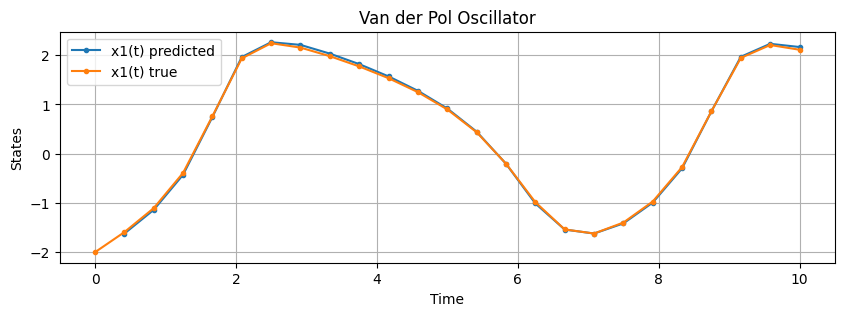

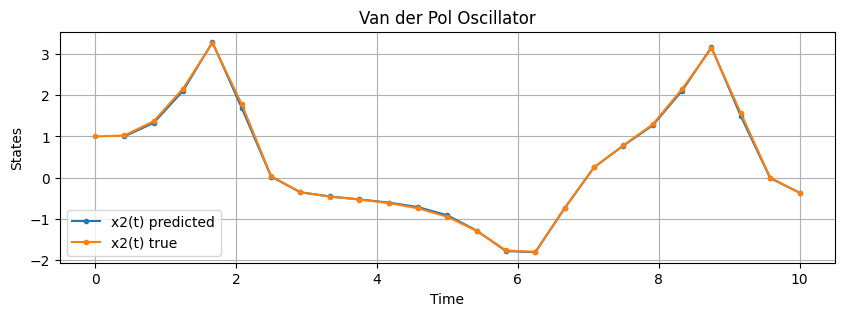

In [12]:
# Plot x1_preds
plt.figure(figsize=(10, 3))
plt.plot(t_val[1:], x1_preds, marker='o', markersize=3, label='x1(t) predicted')
plt.plot(t_val, x1_val, marker='o', markersize=3, label='x1(t) true')
plt.title('Van der Pol Oscillator')
plt.xlabel('Time')
plt.ylabel('States')
plt.legend()
plt.grid(True)
plt.show()

# Plot x2_preds
plt.figure(figsize=(10, 3))
plt.plot(t_val[1:], x2_preds, marker='o', markersize=3, label='x2(t) predicted')
plt.plot(t_val, x2_val, marker='o', markersize=3, label='x2(t) true')
plt.title('Van der Pol Oscillator')
plt.xlabel('Time')
plt.ylabel('States')
plt.legend()
plt.grid(True)
plt.show()

# Control